# Лабораторная работа 7  
## Синтезатор частот с дробным делителем
Выполнила: Шаповалова Виктория, ИКТ-11М.  

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import math

### 2. Схема модели  
В лабораторной работе требуется реализовать синтезатор частот с дробным делителем. За основу будет взят синтезатор из лабораторной работы 6, поэтому он еще раз был промоделирован.

C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\4149902128.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  signal_error[i] = signal_input[i] - signal_out[i]
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\4149902128.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  res_lp[i], LP_integral[i], filter_state = loop_filter_process(filter_state, phase_detector_out[i])
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\4149902128.py:96: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(0, len(phase_vco))/fs_pll*1e6, phase_vco/(2*np.pi*t), '-', label = 'Частота ГУН')


Входной сигнал [0.5       +0.8660254j  0.49454877+0.86914988j 0.48907801+0.87224005j ...
 0.5162344 +0.85644734j 0.51084303+0.85967401j 0.50543149+0.86286674j], Выходной сигнал [0.         0.99998026 0.99989232 ... 0.41628079 0.44463518 0.47255076], M = 1000, N = 5


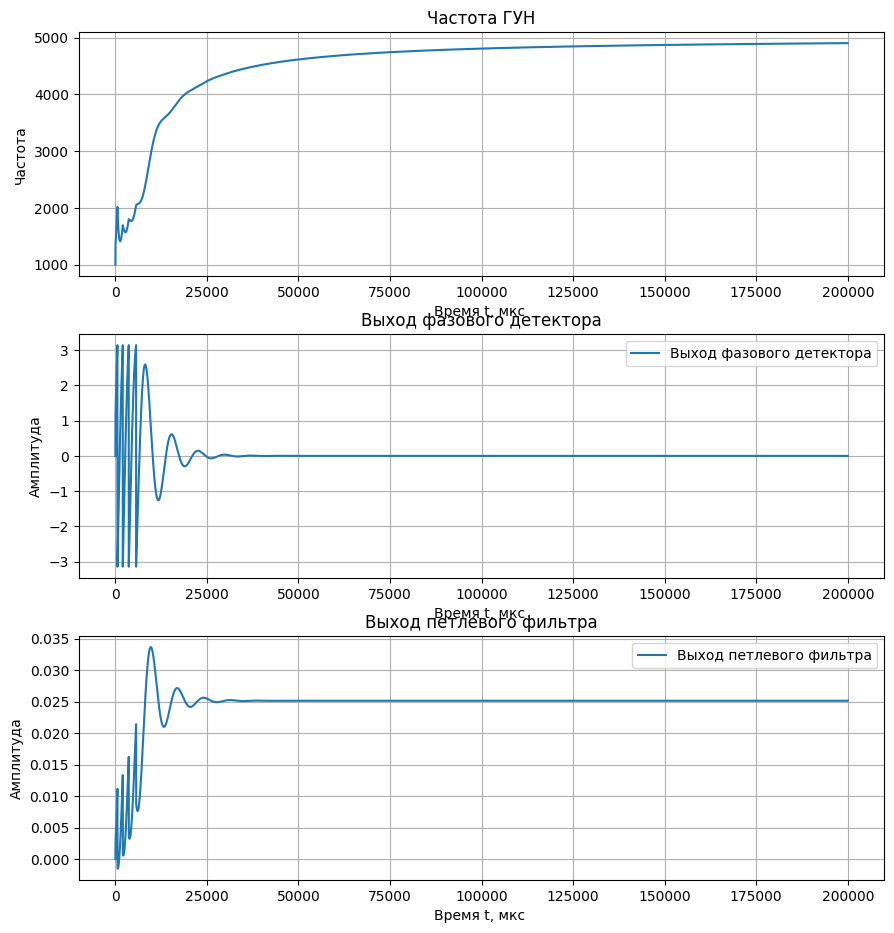

In [55]:
def vco(delta_phase_LP, state):
    state['phase'] += state['K_vco'] * delta_phase_LP + state['delta_phase_VCO']
    complex_signal = np.exp(1j * state['phase']) 
    return complex_signal, state['phase'], state

def PhaseDetector(input, vco, K_pd):
    err = np.angle(input*np.conjugate(vco))
    return K_pd*err


def phase_unwrap_lp(phase):
    while phase > 2*np.pi:
        phase -= 2*np.pi
    while phase < -2*np.pi:
        phase += 2*np.pi
    return phase

def create_loop_filter(fs, K_pd, K_nco):
    damping_factor = np.sqrt(2)/2
    natural_freq = 2*np.pi*fs/5000
    equivalent_noise_bandwidth = natural_freq/2*(damping_factor + 1/(4*damping_factor))
    
    K_p = 1/(K_pd*K_nco)*(4*damping_factor/(damping_factor + 1/(4*damping_factor)))*equivalent_noise_bandwidth/fs
    K_i = 1/(K_pd*K_nco)*(4/(damping_factor + 1/(4*damping_factor))**2)*(equivalent_noise_bandwidth/fs)**2
    
    return {
        'integral_part': 0,
        'damping_factor': damping_factor,
        'natural_freq': natural_freq,
        'equivalent_noise_bandwidth': equivalent_noise_bandwidth,
        'K_p': K_p,
        'K_i': K_i
    }

def update_loop_filter_params(state, fs, K_pd, K_nco):
    state['equivalent_noise_bandwidth'] = state['natural_freq']/2*(state['damping_factor'] + 1/(4*state['damping_factor']))
    state['K_p'] = 1/(K_pd*K_nco)*(4*state['damping_factor']/(state['damping_factor'] + 1/(4*state['damping_factor'])))*state['equivalent_noise_bandwidth']/fs
    state['K_i'] = 1/(K_pd*K_nco)*(4/(state['damping_factor'] + 1/(4*state['damping_factor']))**2)*(state['equivalent_noise_bandwidth']/fs)**2
    return state


def loop_filter_process(state, error_sample):
    proportional_part = state['K_p'] * error_sample
    state['integral_part'] += state['K_i'] * error_sample
    output = proportional_part + state['integral_part']
    return output, state['integral_part'], state

def Freq_synth(M, N, fs_pll, f_sig, f_vco, p_sig, K_pd, K_vco, number_periods):

    t = np.arange(0, number_periods*fs_pll/(f_sig/M))/fs_pll
    signal_input = np.exp(1j*(2*np.pi*f_sig/M*t+p_sig))

    filter_state = {
        'integral_part': 0,
        'damping_factor': 0.5,
        'natural_freq': 2*np.pi*fs_pll/1000,
        'equivalent_noise_bandwidth': 0.001*fs_pll,
        'K_p' : 1/(K_pd*K_vco)*(4*0.5/(0.5 + 1/(4*0.5)))*0.001*fs_pll/fs_pll,
        'K_i' : 1/(K_pd*K_vco)*(4/(0.5 + 1/(4*0.5))**2)*(0.001*fs_pll/fs_pll)**2
    }

    res_lp = np.zeros(shape=np.shape(signal_input))
    LP_integral = np.zeros(shape=np.shape(signal_input))


    vco_state = {
        'phase': 0,
        'delta_phase_VCO': 2*np.pi*f_vco/fs_pll,  
        'K_vco': K_vco                       
    }

    res_vco = np.zeros(shape=np.shape(signal_input), dtype=complex)
    phase_vco = np.zeros(shape=np.shape(signal_input))
    vco_out = np.zeros(shape=np.shape(signal_input), dtype=complex)

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)


    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        res_vco[i], phase_vco[i], vco_state = vco(res_lp[i-1], vco_state)
        
        signal_out[i] = np.real(res_vco[i])
        vco_out[i] = np.exp(1j*phase_vco[i]/N)
        signal_error[i] = signal_input[i] - signal_out[i]
    
        phase_detector_out[i] = PhaseDetector(signal_input[i], vco_out[i], 1)
        res_lp[i], LP_integral[i], filter_state = loop_filter_process(filter_state, phase_detector_out[i])
    
    plt.figure(figsize=(9,9))

    plt.subplot(3, 1, 1)
    plt.plot(np.arange(0, len(phase_vco))/fs_pll*1e6, phase_vco/(2*np.pi*t), '-', label = 'Частота ГУН')
    plt.title('Частота ГУН')
    plt.xlabel('Время t, мкс ')
    plt.grid()
    plt.ylabel('Частота')
    plt.tight_layout()
    
    plt.subplot(3, 1, 2)
    plt.plot(np.arange(0, len(phase_detector_out))/fs_pll*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
    plt.title('Выход фазового детектора')
    plt.xlabel('Время t, мкс ')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(np.arange(0, len(res_lp))/fs_pll*1e6, res_lp, '-', label = 'Выход петлевого фильтра')
    plt.title('Выход петлевого фильтра')
    plt.xlabel('Время t, мкс ')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.legend()

    
    return signal_input, signal_out

fs_pll = 1e6
f_vco = 1e3
f_sig = 1e6
p_sig = np.pi/3
K_pd = 1
K_vco = 1
number_periods = 200
M = 1000
N = 5

signal_input, signal_output = Freq_synth(M, N, fs_pll, f_sig, f_vco, p_sig, K_pd, K_vco, number_periods)
print(f'Входной сигнал {signal_input}, Выходной сигнал {signal_output}, M = {M}, N = {N}')

### 3. Дробное деление  
Для реализации дробного делителя в схеме синтезатора требуется заменить деление phase_vco[i] / N методом, основанным на чередовании целых делителей. Этот метод позволяет получить среднее значение делителя, равное дробному N, за счёт изменения делителя между двумя ближайшими целыми числами в определённой последовательности. Потребность в таком методе связана с непосредственной реальной реализацией синтезатора частот.  
Таким образом, была реализована следующая функция: число N делится на целую и дробную части, если N дробное, то на каждом шаге к дробной части N_frac добавляется остаток, и если он превышает 1, то используется N_int + 1, а из аккумулятора вычитается 1.

In [56]:
def fractional_division(phase_vco_i, N, acc):
    N_int = int(N)
    N_frac = N - N_int

    acc += N_frac
    if acc >= 1.0:
        divs = N_int + 1
        acc -= 1.0
    else:
        divs = N_int
    
    res = phase_vco_i / divs
    return res, acc

Далее переписана функция синтезатора с внедрением делителя.

C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  signal_error[i] = signal_input[i] - signal_out[i]
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  res_lp[i], LP_integral[i], filter_state = loop_filter_process(filter_state, phase_detector_out[i])
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:50: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(0, len(phase_vco))/fs_pll*1e6, phase_vco/(2*np.pi*t), '-', label = 'Частота ГУН')


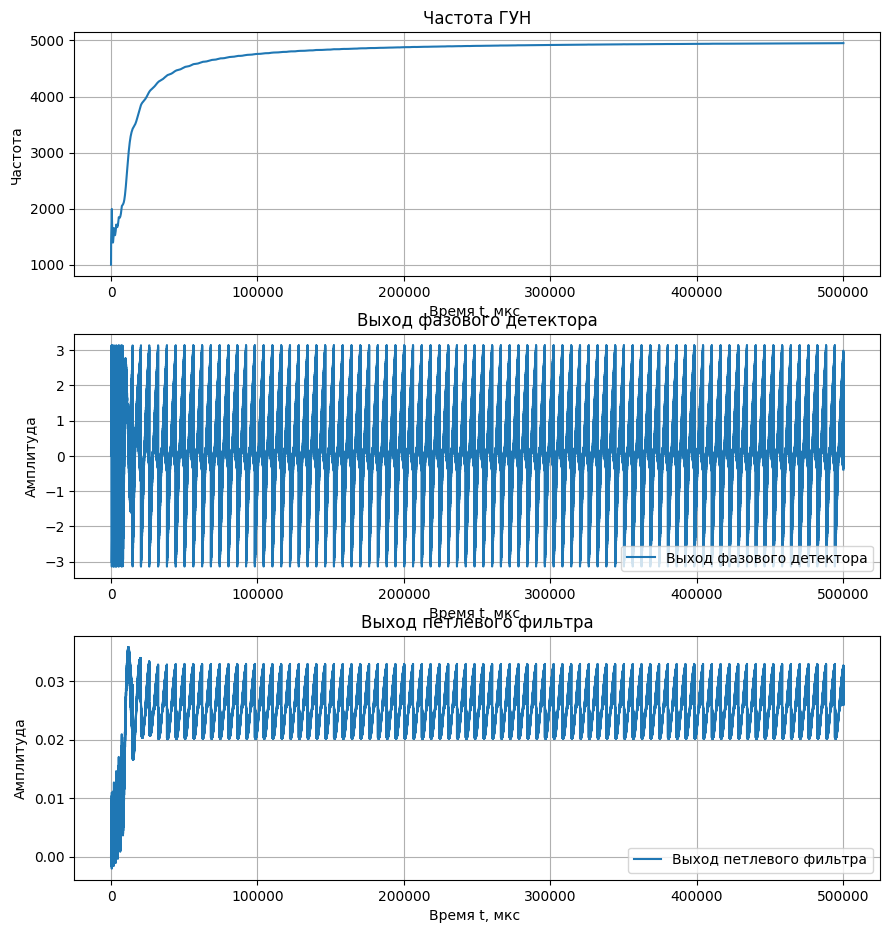

In [57]:
def Freq_frac_synth(M, N, fs_pll, f_sig, f_vco, p_sig, K_pd, K_vco, number_periods):

    t = np.arange(0, number_periods*fs_pll/(f_sig/M))/fs_pll
    signal_input = np.exp(1j*(2*np.pi*f_sig/M*t+p_sig))

    filter_state = {
        'integral_part': 0,
        'damping_factor': 0.5,
        'natural_freq': 2*np.pi*fs_pll/1000,
        'equivalent_noise_bandwidth': 0.001*fs_pll,
        'K_p' : 1/(K_pd*K_vco)*(4*0.5/(0.5 + 1/(4*0.5)))*0.001*fs_pll/fs_pll,
        'K_i' : 1/(K_pd*K_vco)*(4/(0.5 + 1/(4*0.5))**2)*(0.001*fs_pll/fs_pll)**2
    }

    res_lp = np.zeros(shape=np.shape(signal_input))
    LP_integral = np.zeros(shape=np.shape(signal_input))


    vco_state = {
        'phase': 0,
        'delta_phase_VCO': 2*np.pi*f_vco/fs_pll,  
        'K_vco': K_vco                       
    }

    res_vco = np.zeros(shape=np.shape(signal_input), dtype=complex)
    phase_vco = np.zeros(shape=np.shape(signal_input))
    vco_out = np.zeros(shape=np.shape(signal_input), dtype=complex)

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)


    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))

    acc = 0
    for i in np.arange(1, len(signal_input)):
        res_vco[i], phase_vco[i], vco_state = vco(res_lp[i-1], vco_state)
        
        signal_out[i] = np.real(res_vco[i])
        div_out, acc = fractional_division(phase_vco[i], N, acc)
        vco_out[i] = np.exp(1j*div_out)
        signal_error[i] = signal_input[i] - signal_out[i]
    
        phase_detector_out[i] = PhaseDetector(signal_input[i], vco_out[i], 1)
        res_lp[i], LP_integral[i], filter_state = loop_filter_process(filter_state, phase_detector_out[i])
    
    plt.figure(figsize=(9,9))

    plt.subplot(3, 1, 1)
    plt.plot(np.arange(0, len(phase_vco))/fs_pll*1e6, phase_vco/(2*np.pi*t), '-', label = 'Частота ГУН')
    plt.title('Частота ГУН')
    plt.xlabel('Время t, мкс ')
    plt.grid()
    plt.ylabel('Частота')
    plt.tight_layout()
    
    plt.subplot(3, 1, 2)
    plt.plot(np.arange(0, len(phase_detector_out))/fs_pll*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
    plt.title('Выход фазового детектора')
    plt.xlabel('Время t, мкс ')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(np.arange(0, len(res_lp))/fs_pll*1e6, res_lp, '-', label = 'Выход петлевого фильтра')
    plt.title('Выход петлевого фильтра')
    plt.xlabel('Время t, мкс ')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.legend()

    
    return signal_input, signal_out, phase_vco

fs_pll = 1e6
f_vco = 1e3
f_sig = 1e6
p_sig = np.pi/3
K_pd = 1
K_vco = 1
number_periods = 500
M = 1000
N = 5.1

signal_input, signal_output, phase_vco = Freq_frac_synth(M, N, fs_pll, f_sig, f_vco, p_sig, K_pd, K_vco, number_periods)


Полученные графики показывают результат корректной работы синтезатора, поскольку 
$$ f_{vco} = N/M⋅f_{sig}$$
Таким образом, 5.1/1000⋅1e6 = 5100 Гц
Однако, в петлевом фильтре и фазовом детекторе возникают заметные периодические колебания, связанные с реализацией дробного коэффициента деления.  
Также приведено сравнение идеального и синтезированного сигналов.

C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2456025815.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


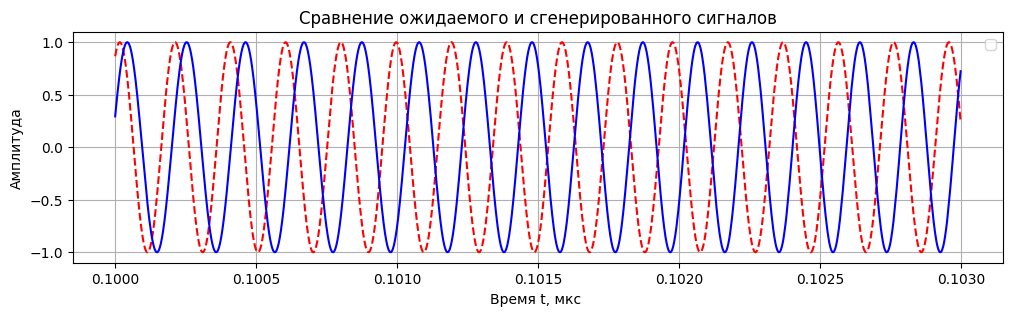

In [58]:
f_ref = f_vco*N
t = np.arange(0, number_periods*fs_pll/(f_sig/M))/fs_pll
ref = np.exp(1j*(2*np.pi*f_ref*t+p_sig))
plt.figure(figsize=(12,3))
plt.plot(t[int(10e4):int(10.3e4)], np.imag(ref[int(10e4):int(10.3e4)]),'--r')
plt.plot(t[int(10e4):int(10.3e4)],signal_output[int(10e4):int(10.3e4)],'b')
plt.title('Сравнение ожидаемого и сгенерированного сигналов')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

Полученные графики показывают, что, начиная с некоторого времени синтезатор выдает нужную частоту. Различия с референсным сигналом присутствуют по фазе.

### 4. Поиск границ работы синтезатора   
В данном разделе, как и для синтезатора с целочисленным делением, исследованы границы корректной работы.

C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  signal_error[i] = signal_input[i] - signal_out[i]
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  res_lp[i], LP_integral[i], filter_state = loop_filter_process(filter_state, phase_detector_out[i])
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:50: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(0, len(phase_vco))/fs_pll*1e6, phase_vco/(2*np.pi*t), '-', label = 'Частота ГУН')
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\3788546806.py:14: RuntimeWarning: invalid value encountered in divide
  p = phase_vco/(2*np.pi*t)


Итоговая частота: 3596.697561258682 для N = 3.5
Итоговая частота: 6343.077799165187 для N = 6.5
Итоговая частота: 8879.527724570857 для N = 9.5
Итоговая частота: 11119.27697422419 для N = 12.5
Итоговая частота: 12320.16989890952 для N = 15.5
Итоговая частота: 13821.655971915894 для N = 18.5
Итоговая частота: 13528.163843845005 для N = 21.5
Итоговая частота: 12170.239710996299 для N = 24.5
Итоговая частота: 9793.944350602807 для N = 27.5


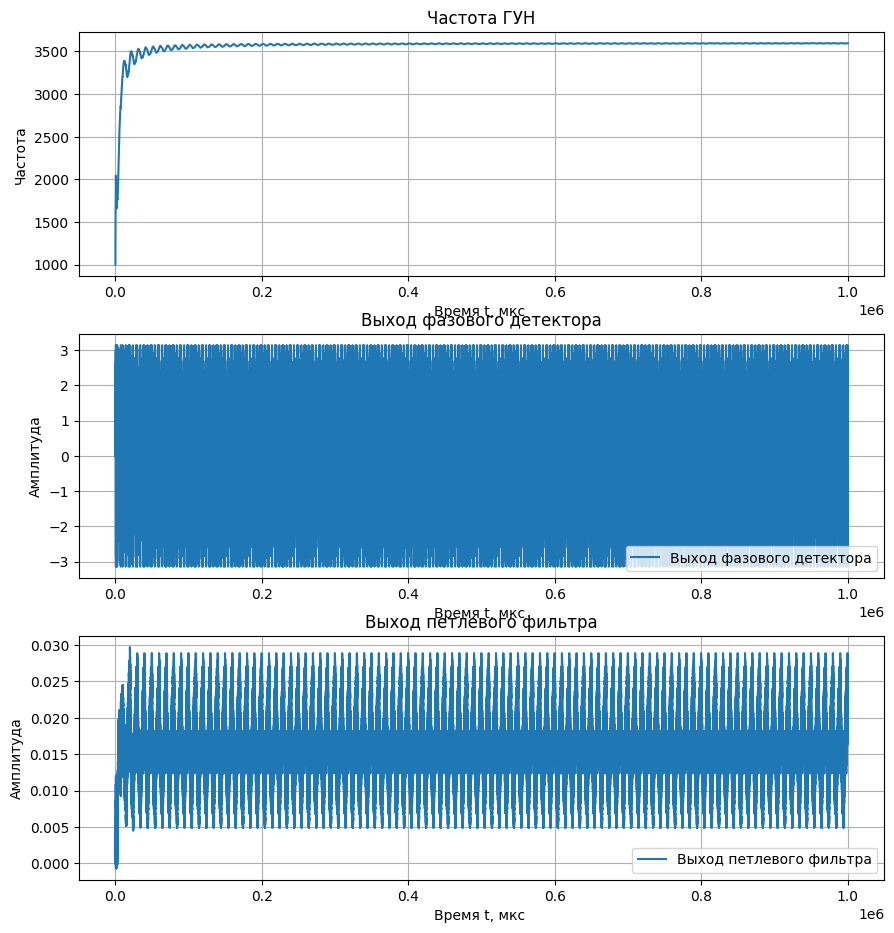

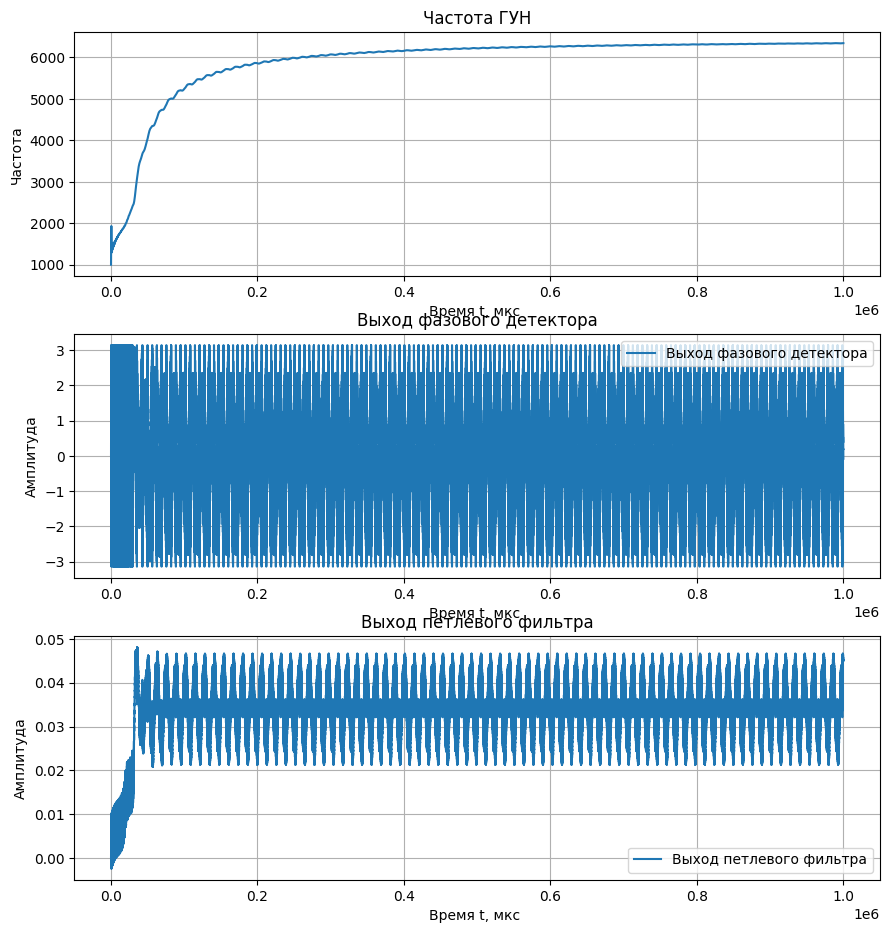

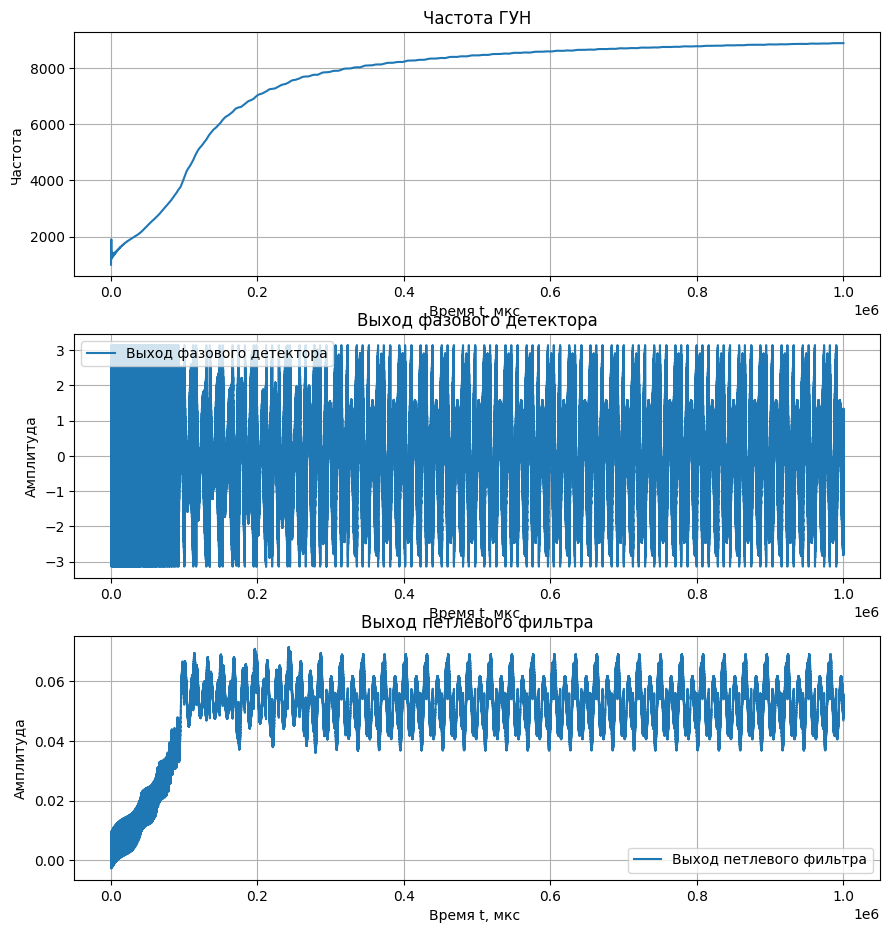

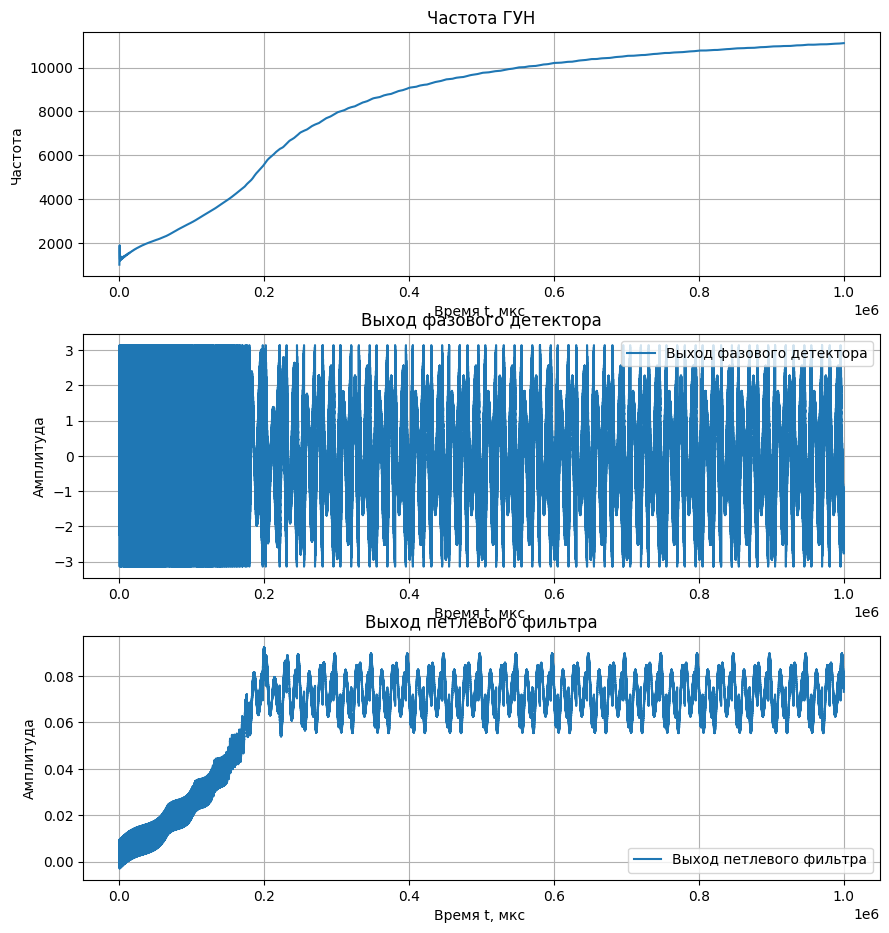

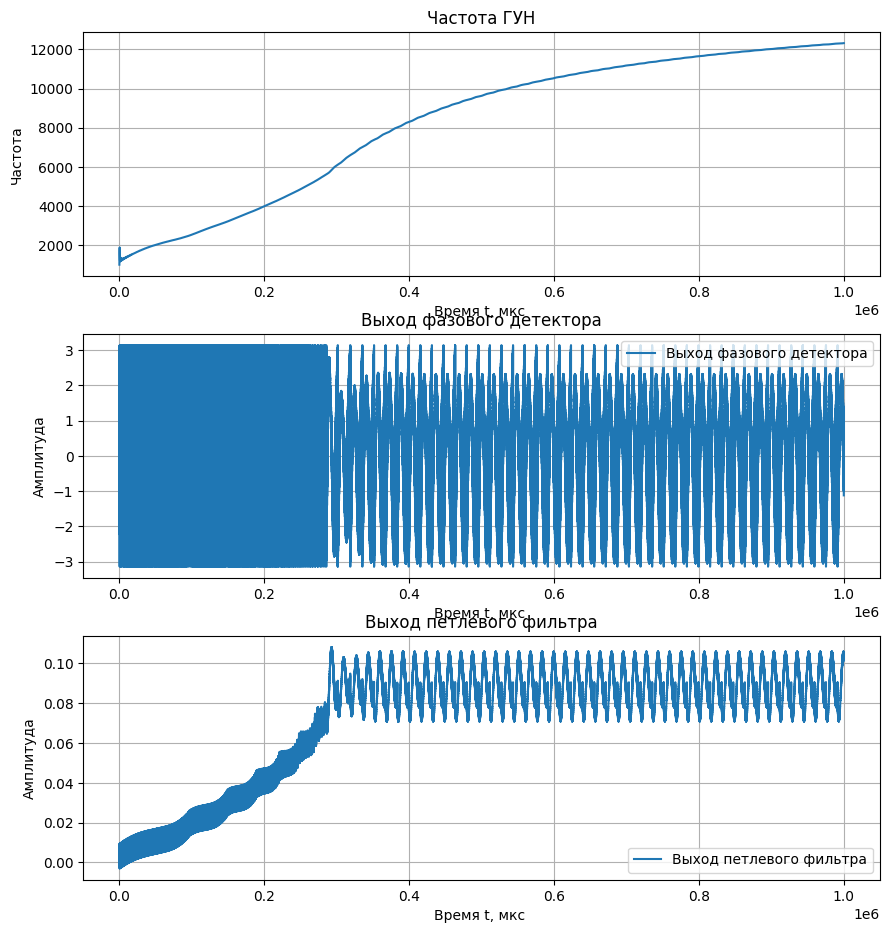

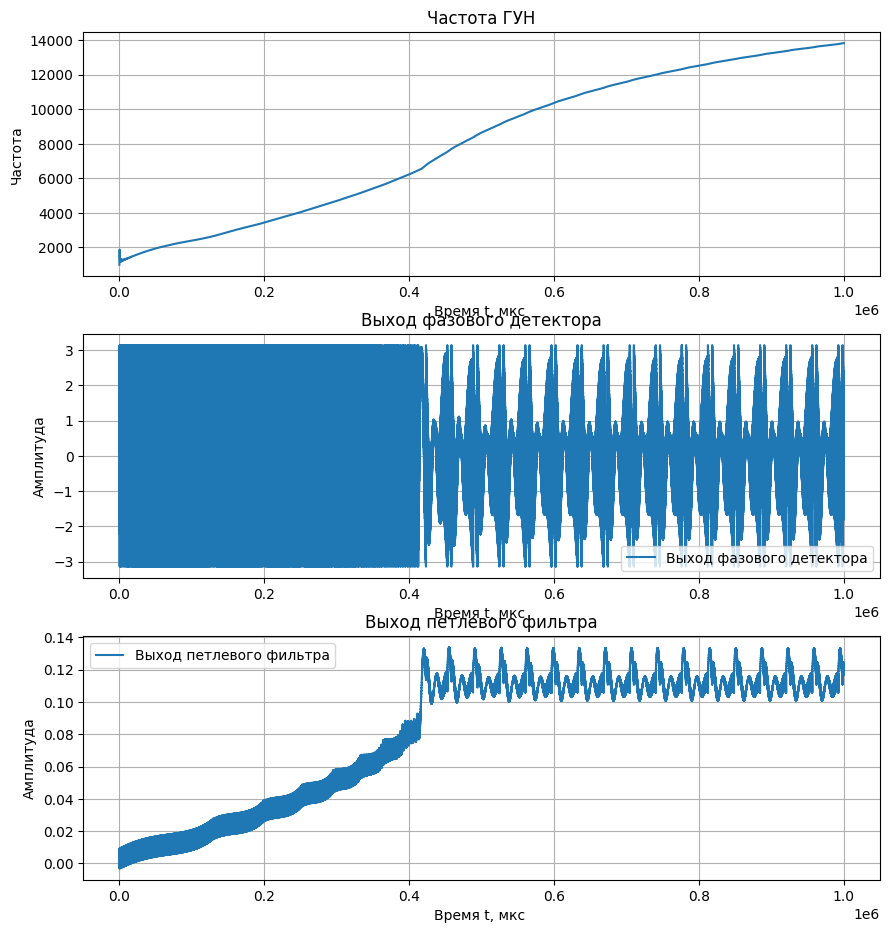

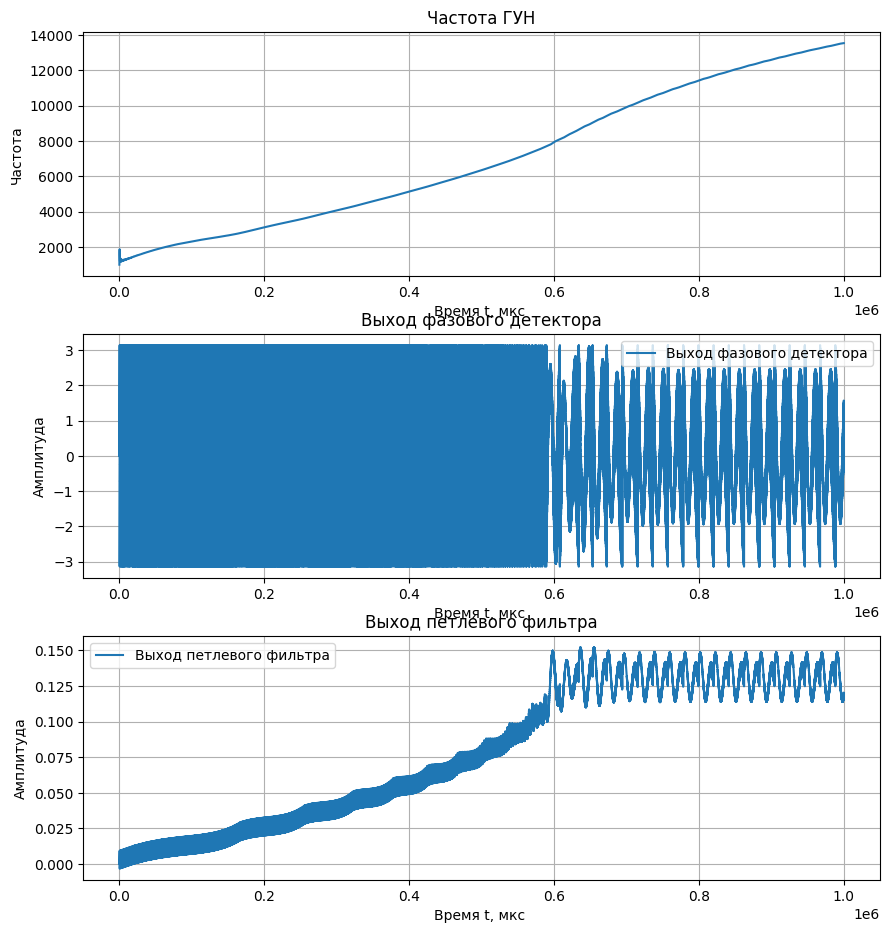

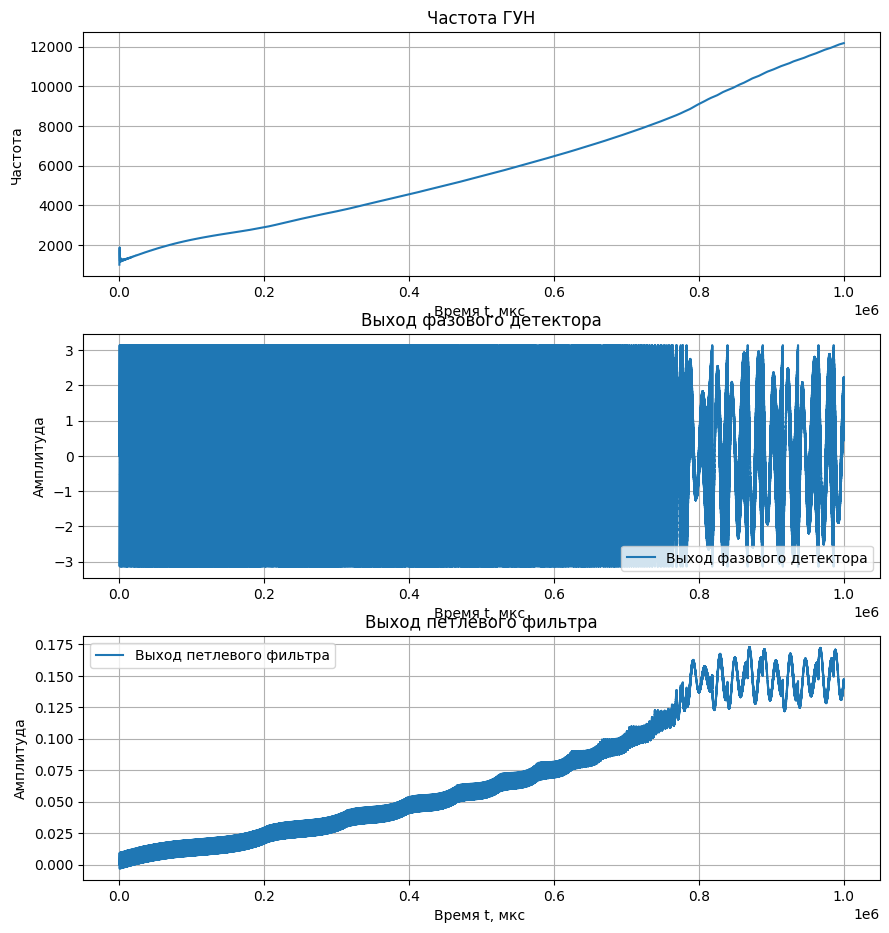

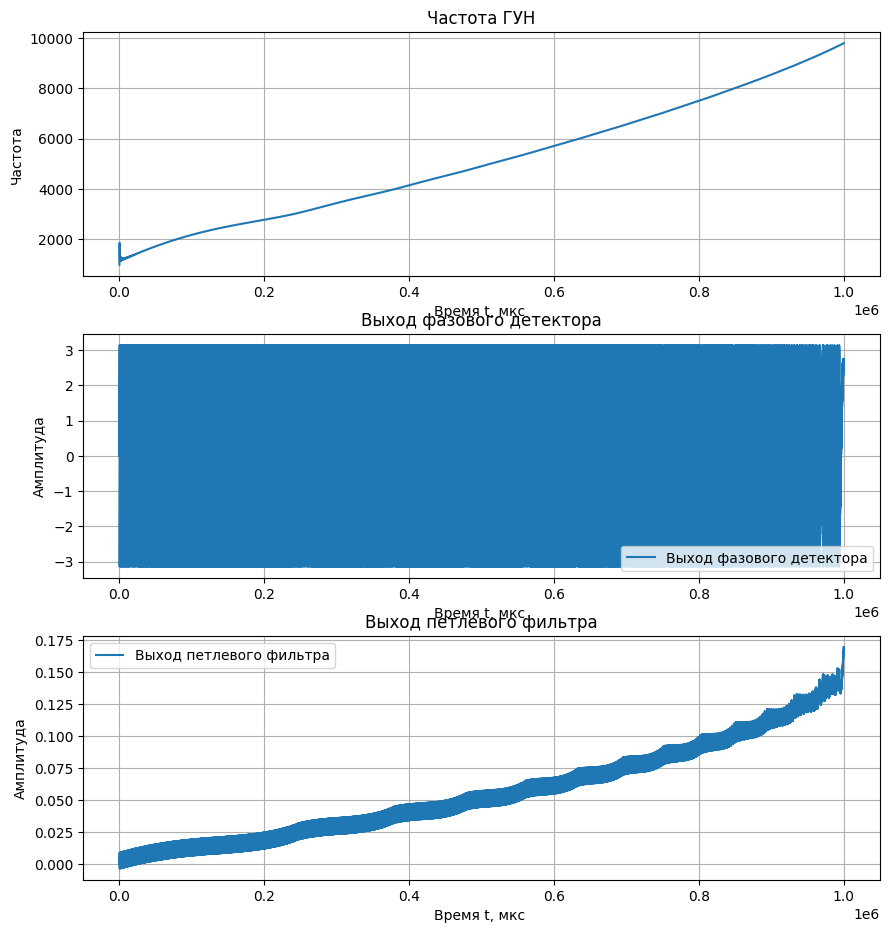

In [59]:
fs_pll = 1e6
f_vco = 1e3
f_sig = 1e6
p_sig = np.pi/3
K_pd = 1
K_vco = 1
number_periods = 1000
M = 1000
N = np.arange(1, 10)*3

for n in N:
    signal_input, signal_output, phase_vco = Freq_frac_synth(M, n+0.5, fs_pll, f_sig, f_vco, p_sig, K_pd, K_vco, number_periods)
    t = np.arange(0, number_periods*fs_pll/(f_sig/M))/fs_pll
    p = phase_vco/(2*np.pi*t)
    print(f'Итоговая частота: {p[-1]} для N = {n}.5')

Полученные графики показывают, что с увеличением значения N, синтезатору требуется всё больше времени для реализации нужной частоты.
Ошибка достижения для разных значений N составляет:  
Для N = 3.5: 96 Гц
Для N = 6.5: 157 Гц
Для N = 9.5: 621 Гц

Вычисление ошибки для других графиков является некорректным, поскольку синтезатор еще не успел настроить нужную частоту. Однако, в целом, полученные рещзультаты показывают, что ошибка синтезатора составляет примерно 3%, но растет с увеличением значения N.

### 5. Исследование зависимости от N  
Также проведена оценка зависимости от величины дробной части N. Значение N изменялось от 5.1 до 6 с шагом 0.1.

C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  signal_error[i] = signal_input[i] - signal_out[i]
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  res_lp[i], LP_integral[i], filter_state = loop_filter_process(filter_state, phase_detector_out[i])
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\2593139541.py:50: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(0, len(phase_vco))/fs_pll*1e6, phase_vco/(2*np.pi*t), '-', label = 'Частота ГУН')
C:\Users\Victoria\AppData\Local\Temp\ipykernel_21632\4055900770.py:14: RuntimeWarning: invalid value encountered in divide
  p = phase_vco/(2*np.pi*t)


Итоговая частота: 4975.79774015886 для N = 5.1
Итоговая частота: 4971.563650905219 для N = 5.2
Итоговая частота: 4960.568547643627 для N = 5.3
Итоговая частота: 5242.846614107735 для N = 5.4
Итоговая частота: 5491.8847900491855 для N = 5.5
Итоговая частота: 5916.052789865427 для N = 5.6
Итоговая частота: 5922.090483036694 для N = 5.7
Итоговая частота: 5934.6292150802155 для N = 5.8
Итоговая частота: 5947.09851729723 для N = 5.9


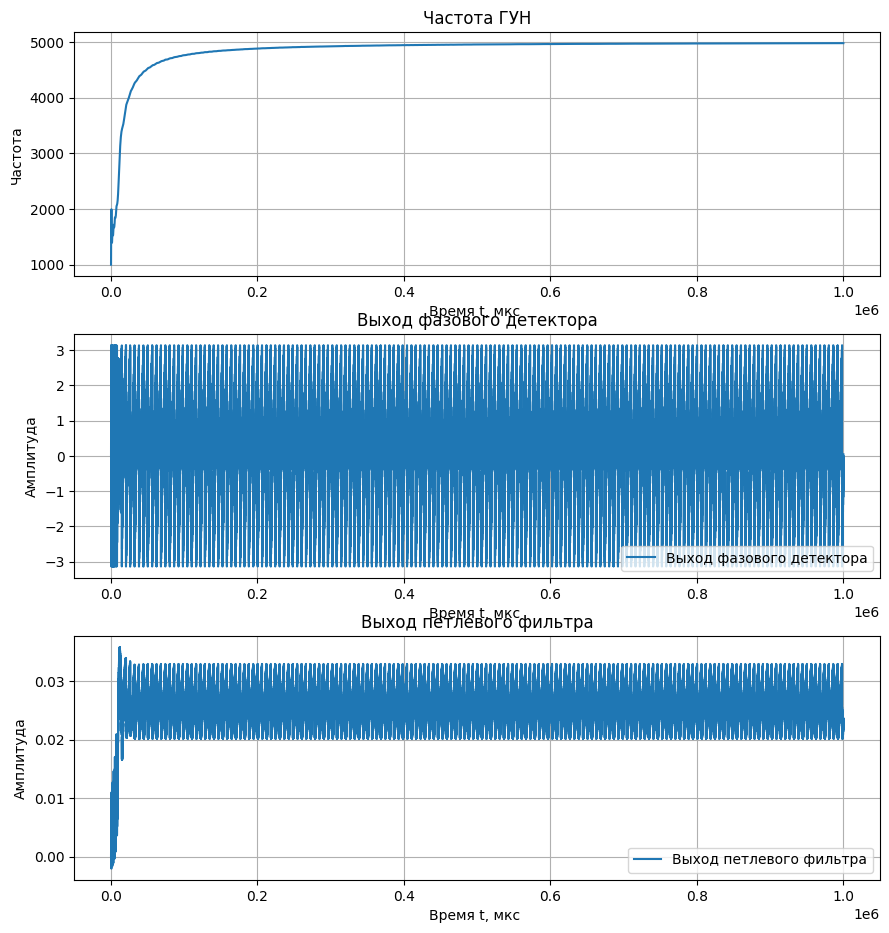

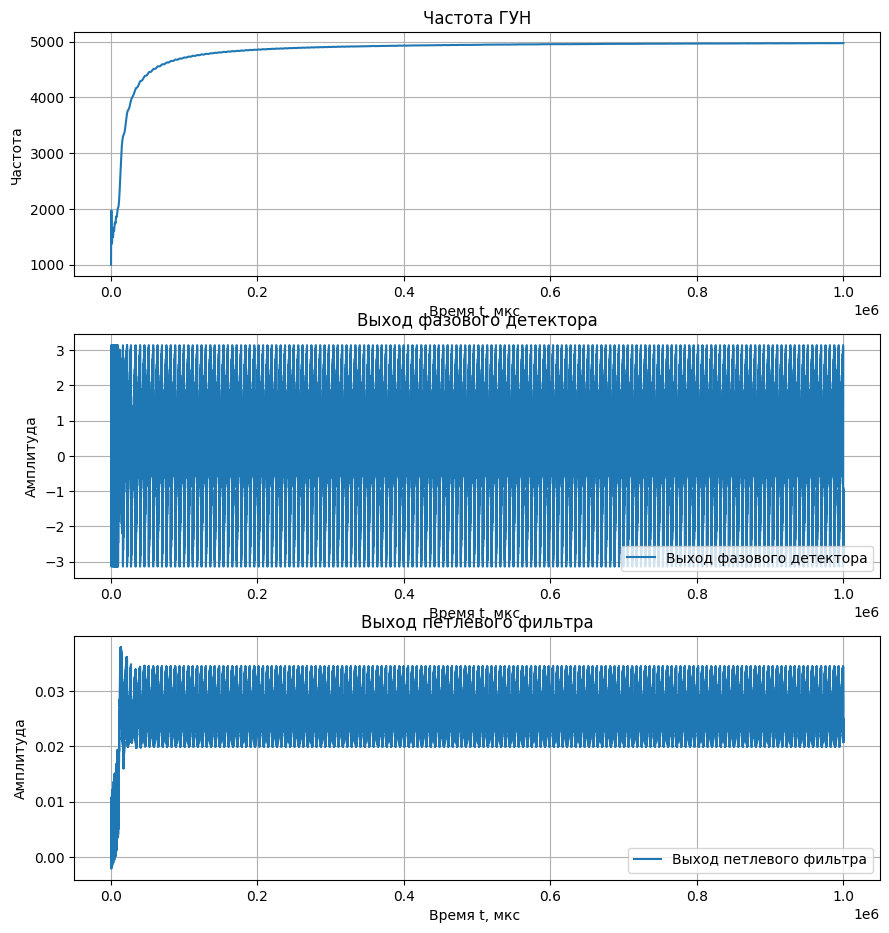

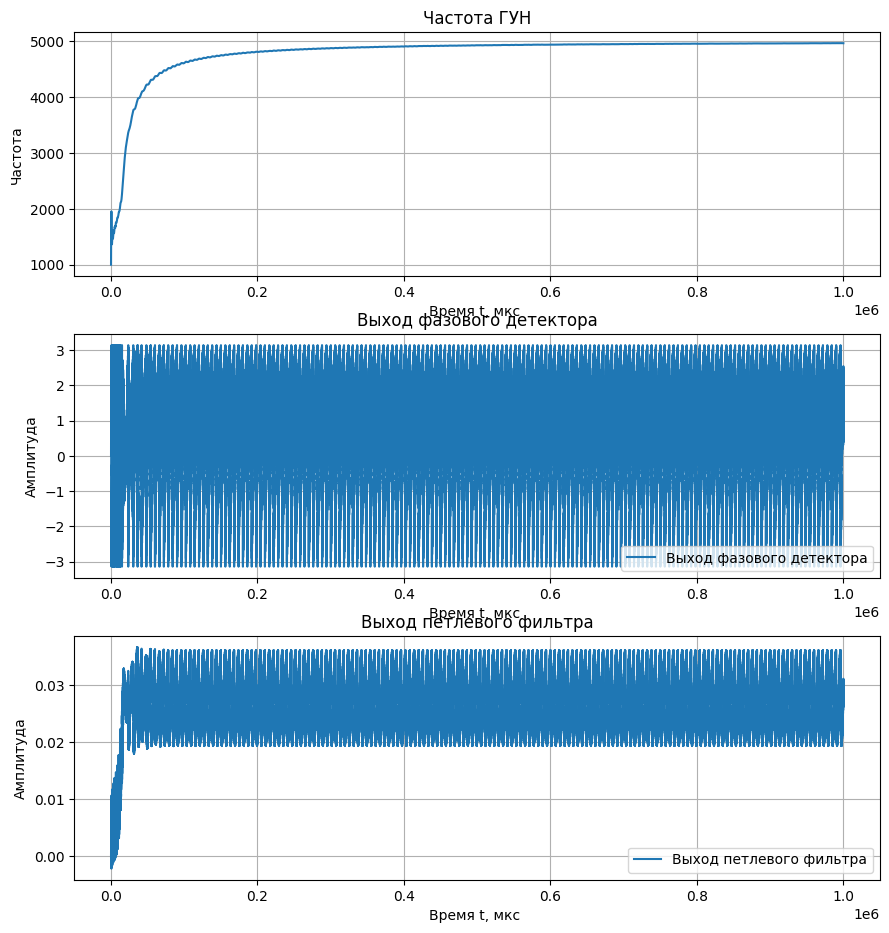

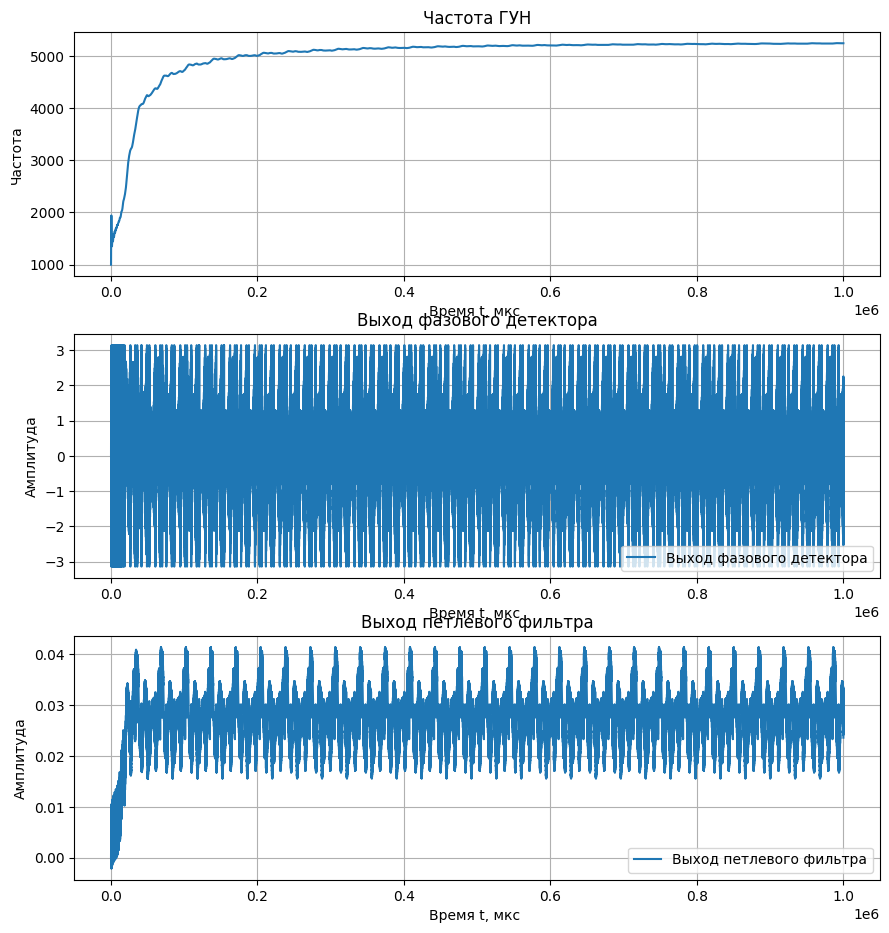

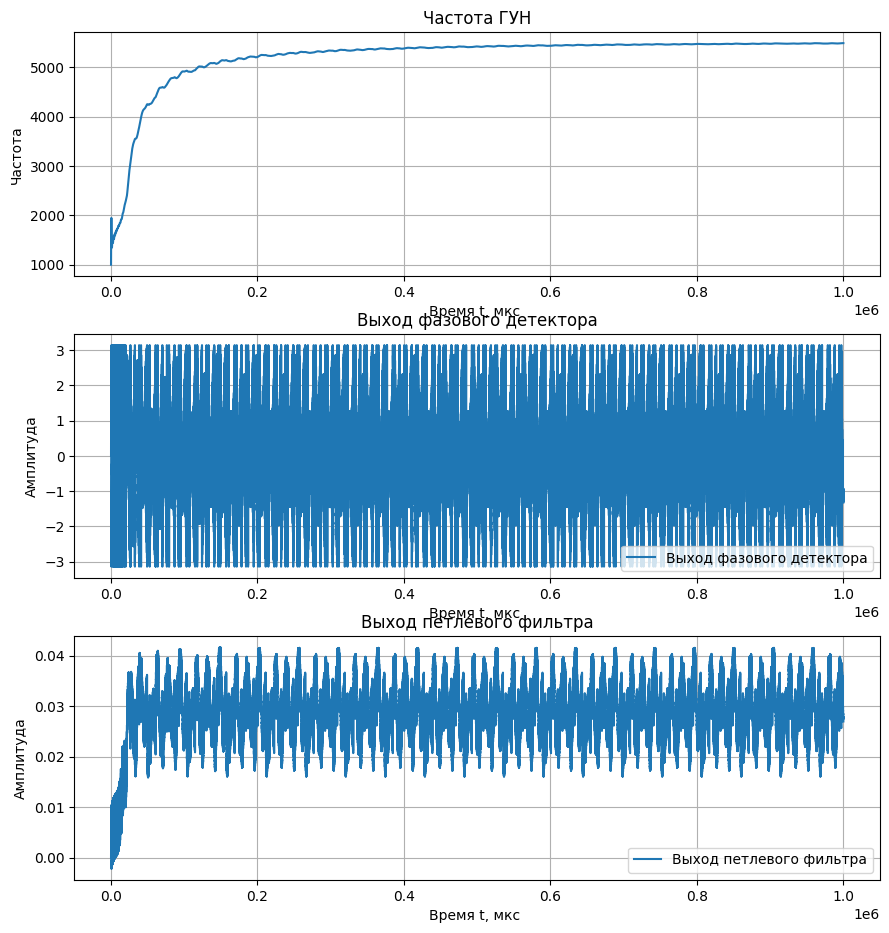

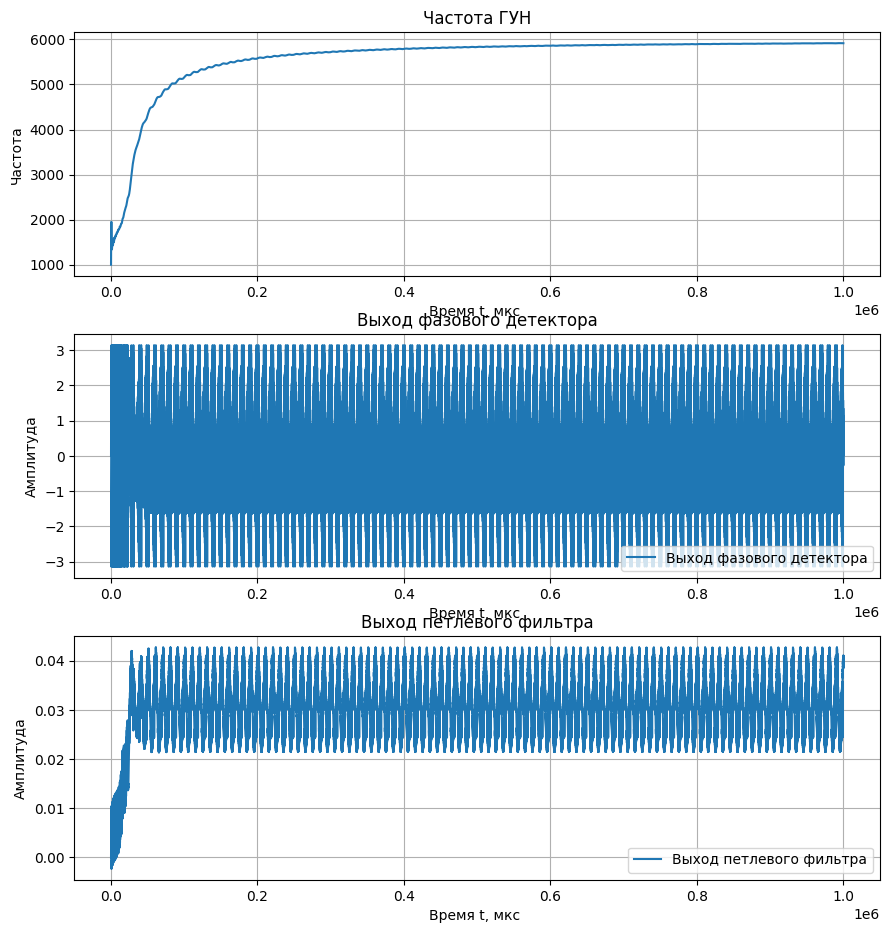

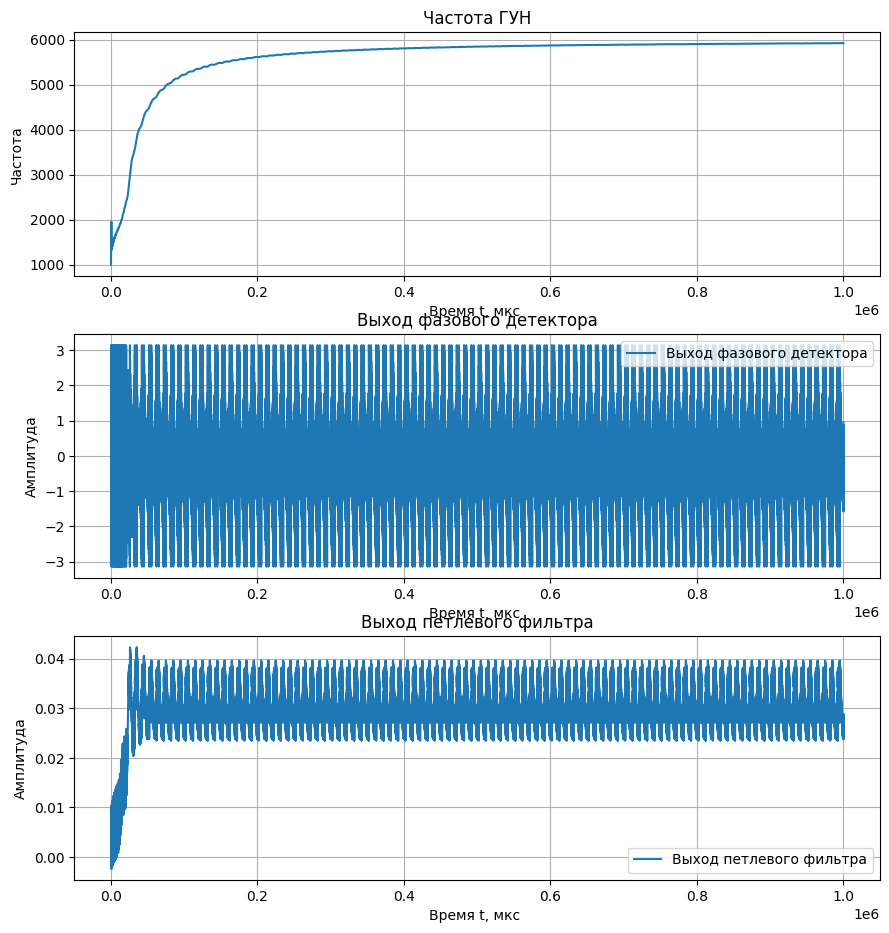

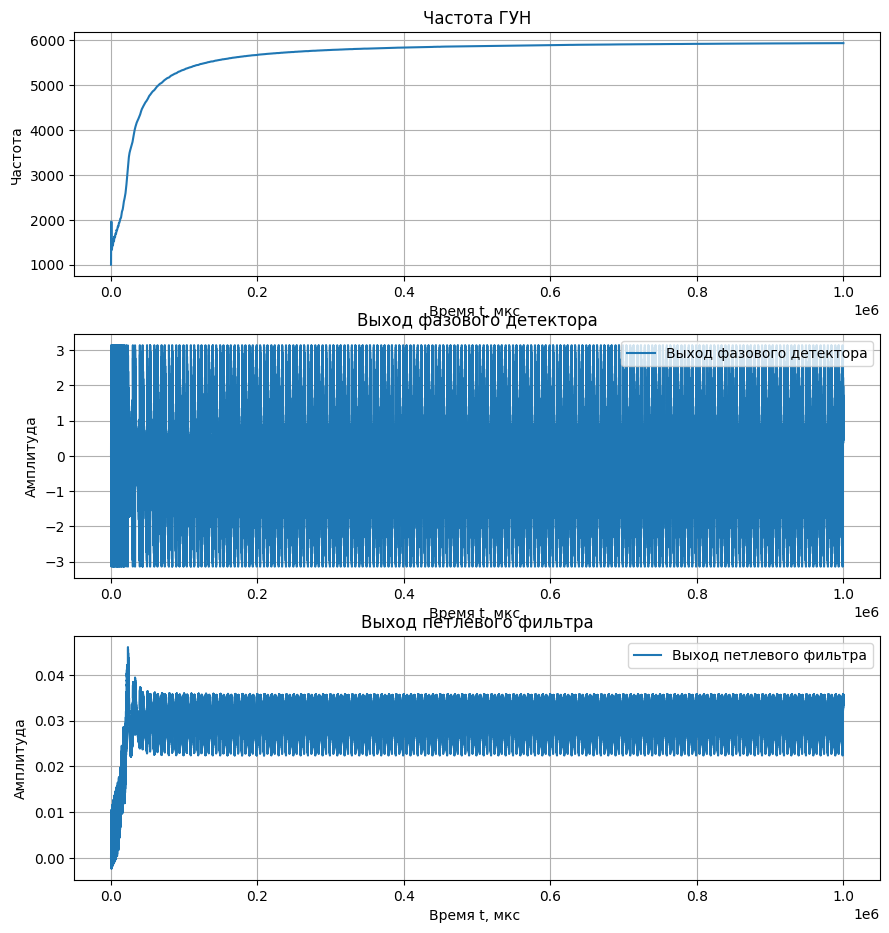

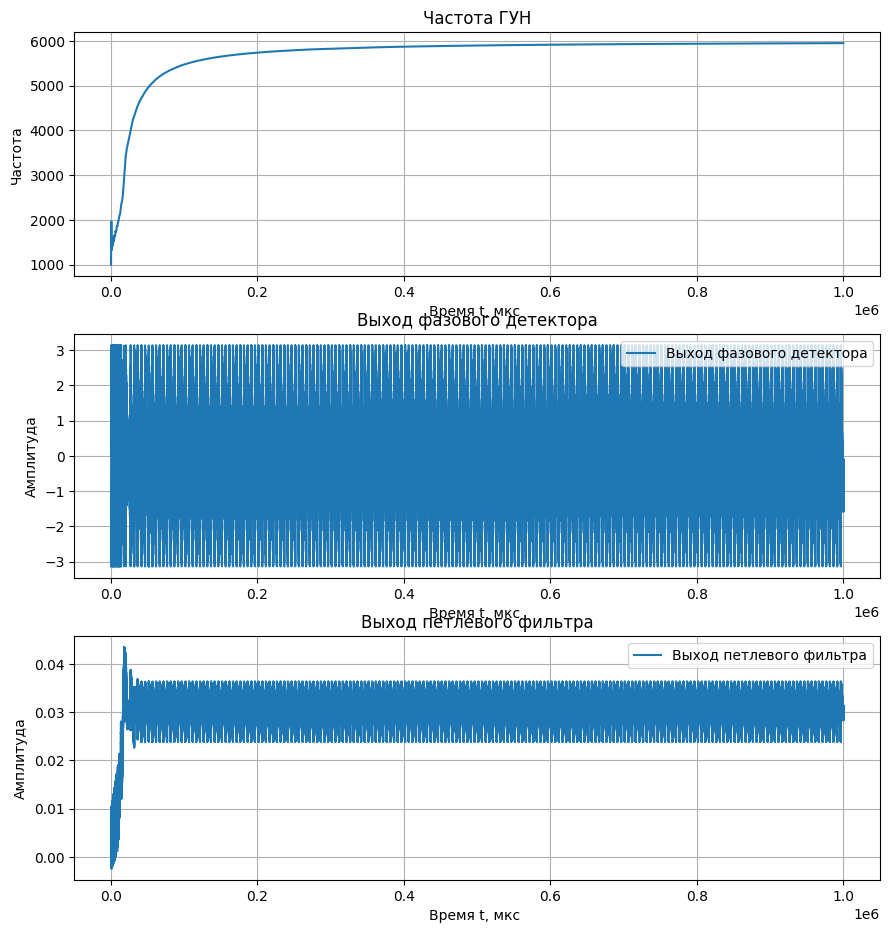

In [60]:
fs_pll = 1e6
f_vco = 1e3
f_sig = 1e6
p_sig = np.pi/3
K_pd = 1
K_vco = 1
number_periods = 1000
M = 1000
N = np.arange(1, 10)

for n in N:
    signal_input, signal_output, phase_vco = Freq_frac_synth(M, 5+0.1*n, fs_pll, f_sig, f_vco, p_sig, K_pd, K_vco, number_periods)
    t = np.arange(0, number_periods*fs_pll/(f_sig/M))/fs_pll
    p = phase_vco/(2*np.pi*t)
    print(f'Итоговая частота: {p[-1]} для N = 5.{n}')

Результаты вычисления ошибки показывают, что наиболее точное значение обеспечивается при величине дробной части равной 0.5, это связано с методом получения дробной части.

## Вывод  
В ходе выполнения лабораторной работы был повторен синтезатор частот на основе ФАПЧ, реализованный в ЛР6. Затем он был изменен, путем реализации дробного делителя с помощью метода последовательного деления на соседние целые числа. Такой метод позволил получить желаемую частоту, однако на выходе составляющих блоков синтезатора появился джиттер, связанный с реализацией метода.   
Далее была исследована зависимость результатов работы синтезатора при разных значениях дробного N. Полученные графики показывают, что с увеличением значения N, синтезатору требуется всё больше времени для реализации нужной частоты, а также постепенно растет ошибка получаемой частоты.   
Исследование зависимости результатов от величины дробной части N показывает, что наименьшая ошибка, а значит наиболее точное значение частоты на выходе синтезатора обеспенчивается при величине дробной части равной 0,5.   
Таким образом, синтезатор частот с дробным делителем обеспечивает достижение нужного значения частоты, однако с некоторой погрешностью, поэтому не может использоваться в точных системах.